# Deep Convolutional GAN

 Implementation and training of DCGAN (https://arxiv.org/abs/1511.06434) using CIFAR-10 dataset.

### Setup

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None, h=None, resize=False):
    ''' Denomrmalises image for viewing.'''
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x


def show(img):
    '''Displays image.'''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx)
                          if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./DCGAN'):
    os.makedirs('./DCGAN')

cuda:0


### Data loading

In [11]:
batch_size = 128  
NUM_TRAIN = 49000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                                 transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                               transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True,
                                transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [12]:
num_epochs = 20
learning_rate = 0.0002
latent_vector_size = 100
num_channels = 3

### Model definition

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generate = nn.Sequential(
            # input is latent space vector
            nn.ConvTranspose2d(latent_vector_size, 64 * \
                               8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 32 x 32
        )

    def decode(self, z):
        x = self.generate(z)
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            # Input is 32x32x3 colour image
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 16 x 16
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 8 x 8
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*4) x 4 x 4
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*8) x 2 x 2
            nn.Conv2d(64 * 8, 1, 4, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def discriminator(self, x):
        out = self.discriminate(x)
        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    '''Initialises NN weights.'''
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [15]:
use_weights_init = True


# Generator
model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

# Discriminator
model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3448576
Generator(
  (generate): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 2765568
Discriminator(
  (discrimin

### Define loss function

In [16]:
criterion = nn.BCELoss(reduction='mean')

def loss_function(out, label):
    '''Helper function.'''
    loss = criterion(out, label)
    return loss

### Initialize optimizers

In [17]:
# setup optimizer
beta1 = 0.5
optimizerD = torch.optim.Adam(
    model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, 1)

optimizerG = torch.optim.Adam(
    model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, 1)

### Define fixed input vectors to monitor training and mode collapse.

In [18]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [ ]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size,
                            1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()
#         schedulerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()
#         schedulerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(),
                   './DCGAN/real_samples.png')

    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(),
               './DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save losses and models
torch.save(model_G.state_dict(), './DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './DCGAN/DCGAN_model_D.pth')



A DCGAN is presented above. The generator was implemented to upsample a latent vector of size 100 to a [3,32,32] size matrix representing a color image. The upsampling was done using transpose convolutions. I experimented with various sizes of latent vector. I found that if it was too small, there was not enough information contained within it to recreate any detail in the images, and all generated images contained almost no structure. If the latent vector was too large the training became unstable - a latent vector size of 100 was found to be a reasonable compromise.

There is an inherent instability while training GANS, as the loss function performs a kind of 'mini-max' game between the generator and the descriminator - measuring how well each component is doing compared to its opponent. I therefore found the training to be very sensitive to hyper parameters. When I trained the network for longer than 20 epochs I got total mode collapse. I tried to stabilise training as much as possible by using batch normalisation, and the LeakyReLU (to help with vanishing gradients).

Since the images are relatively small (only [3,32,32]), a very deep network was not required either for the discriminator or the generator. However, if larger images were to be used, further layers would probably need to be added to both the generator and the descriminator to make sure they have enough capacity to learn from the images. The size of the latent vector may also need to be increased. 

### Generator samples

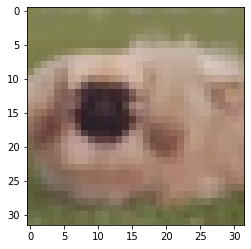

In [20]:
it = iter(loader_test)
sample_inputs, _ = next(it)

for i in range(32):
    fixed_input = sample_inputs[i, :, :, :]
    img = denorm(fixed_input)
    show(img)
    plt.savefig("test" + str(i) + ".pdf")


# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)

show(img)
plt.savefig("test.pdf")

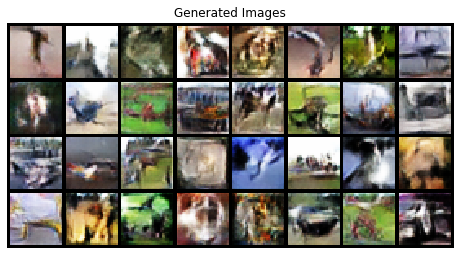

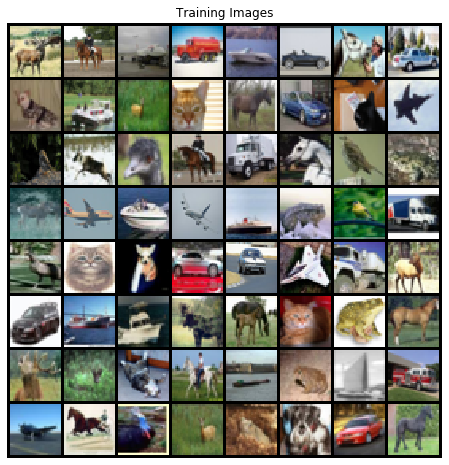

In [21]:
import torchvision.utils as vutils

# load the model
model_G.load_state_dict(torch.load('./DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(denorm(generated)[
               :32], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.savefig("Generated images.png")

# show real images
# Plot some training images
real_batch = next(iter(loader_train))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.savefig("training images.png")


### Train losses curves

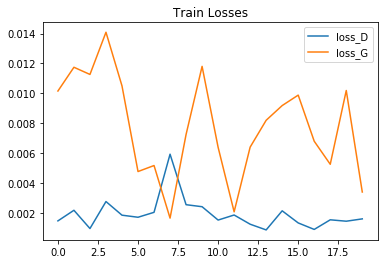

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

plt.plot(
    range(0, np.array(train_losses_D).shape[0]),
    np.array(train_losses_D),
    label='loss_D'
)

plt.plot(
    range(0, np.array(train_losses_G).shape[0]),
    np.array(train_losses_G),
    label='loss_G'
)

plt.legend()
plt.title('Train Losses')
plt.show()
plt.savefig("loss_curve.png")


It can be seen from the plot that training was not particularly stable, due to the large fluctuations in loss for both the descriminator and generator. 

There is, however, a general downward trend of the generator loss. This is theoretically sensible, as the generator should be getting better at generating images that fool the discriminator. As it gets better, it's loss decreases.

The descriminator loss, however, remains relatively constant. This implies that the descriminator's weights are not being updated as quickly as the generator - and perhaps that the discriminator is being undertrained. This behaviour could be changed by pre-training the discriminator on real images for a period, before introducing the generator into the model.

### Mode collapse

Mode collapse is when the GAN only learns a small part of the distribution. Most data distributions are multi-modal in real life, so the result of mode collapse is to only represent a small number (or even none) of those modes. This manifests in the network generating images that all look the same (i.e from a single mode of the distribution). 

On observing my generated images from fixed noise, I would expect to see a grid of very similar looking images (as regardless of the input noise, it would always be mapped to an image from a single mode) if there was mode collapse. The images generated by my network, however, are varied and do not all look the same. Although there is certainly variation in the images, there are also noticeable similarities between images - particularly most of the images resemble animals or natural scenes. This is not very surprising given the CIFAR-10 dataset contains alot of pictures of animals, but there is certainly a dominance in my generated images. This would imply partial mode collapse, where animal classes dominate.

Mode collapse can often be attributed to too large a learning rate. The generator will generate images with which to fool the discriminator. If the discriminator is not updated sufficiently often, the generator will learn to generate images with modes (features) which are best at fooling the discriminator at that particular moment. The generator therefore focusses on these modes, and generates an imbalance of modes in training. The discriminator's performance subsequently degrades for other modes. This causes a kind of over-fitting to certain modes during training and results in mode collapse. Mode collapse can thus be targeted by fine-tuning the learning rate. More sophisticated tricks, like the Unrolled GAN could be used to mitigate mode collapse.

